# Bert on 40-10-50 split with 5 epoch

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# these libraries are used for the text cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#these libraries are building the model
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler

# seed for reproducibility
seed = 1111

c:\Developer\cs178-group-project\IMDB_ven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the dataframes
train_data = pd.read_csv("train_review_data.csv",usecols=["review", "label"])
test_data = pd.read_csv("test_review_data.csv", usecols=["review", "label"])
full_data = pd.read_csv("full_review_data.csv", usecols=["review", "label"])

In [3]:
X_train = list(train_data['review'])
X_test = list(test_data['review'])
Y_train = list(train_data['label'])
Y_test = list(test_data['label'])

#splitting the train set into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=seed)

In [4]:
# Construct a BERT tokenizer, reutrns a list of input IDs with the appropriate special tokens.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing function
def tokenize_data(texts, tokenizer, max_len=512):
    return tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",  # Pads to max_len
        truncation=True,      # Truncates to max_len
        return_tensors="pt"   # Returns PyTorch tensors
    )

# Tokenize datasets
train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)

In [5]:
class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = IMDBDataset(train_encodings, Y_train)
val_dataset = IMDBDataset(val_encodings, Y_val)
test_dataset = IMDBDataset(test_encodings, Y_test)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()

# Added seed for reproducibility
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
epochs = 5

# reference: https://stackoverflow.com/questions/60120043/optimizer-and-scheduler-for-bert-fine-tuning
num_training_steps = len(train_loader) * epochs
scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

def train_epoch(model, dataloader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [8]:
def evaluate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []  # To store predictions
    all_labels = []  # To store ground truth labels

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Get model outputs
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            # Get predicted class indices
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Return predictions and labels along with loss and accuracy
    return total_loss / len(dataloader), correct / total, all_preds, all_labels

In [9]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

all_test_preds = []
all_test_labels = []

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scheduler)
    val_loss, val_acc, val_preds, val_labels = evaluate_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

# Evaluate on the test set and retrieve predictions and labels
test_loss, test_acc, test_preds, test_labels = evaluate_epoch(model, test_loader, device)
print()
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Epoch 1/5
Train Loss: 0.2667 | Train Accuracy: 0.8877
Val Loss: 0.1915 | Val Accuracy: 0.9262
Epoch 2/5
Train Loss: 0.1187 | Train Accuracy: 0.9595
Val Loss: 0.2092 | Val Accuracy: 0.9306
Epoch 3/5
Train Loss: 0.0503 | Train Accuracy: 0.9838
Val Loss: 0.2277 | Val Accuracy: 0.9374
Epoch 4/5
Train Loss: 0.0169 | Train Accuracy: 0.9956
Val Loss: 0.2774 | Val Accuracy: 0.9382
Epoch 5/5
Train Loss: 0.0075 | Train Accuracy: 0.9987
Val Loss: 0.3134 | Val Accuracy: 0.9376

Test Loss: 0.2986 | Test Accuracy: 0.9385


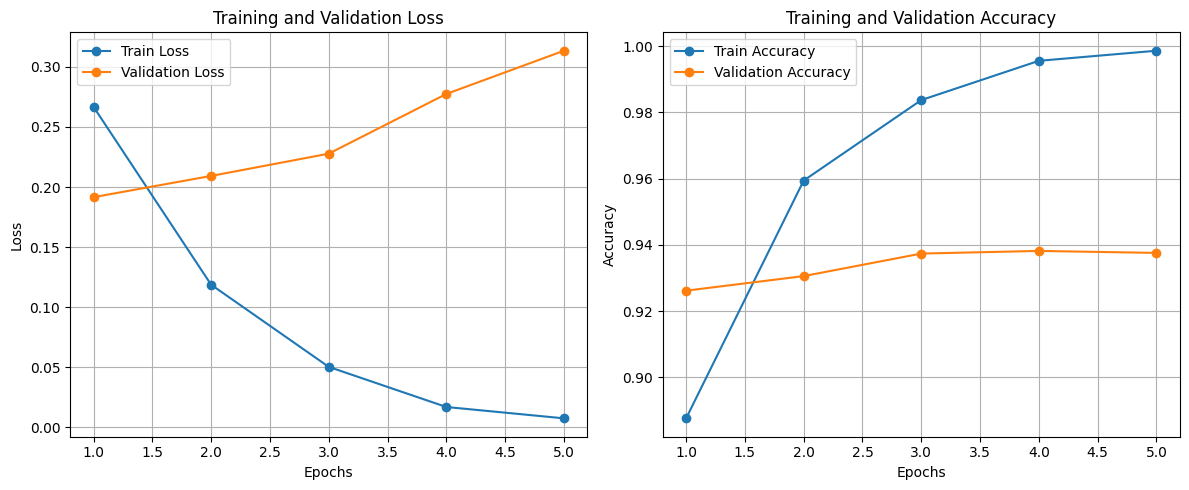

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

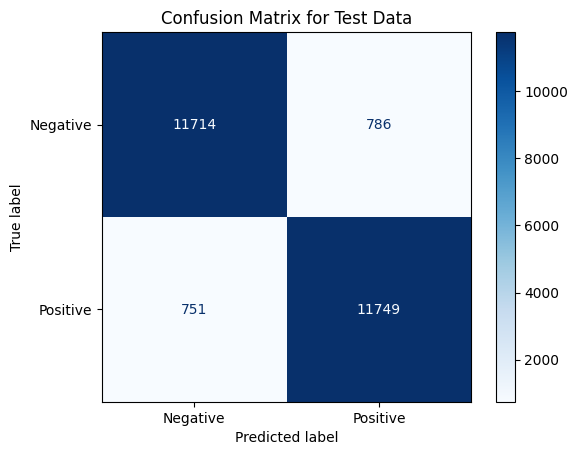

In [11]:
# Generate confusion matrix for the test set
cm = confusion_matrix(test_labels, test_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Test Data")
plt.show()